# Kuzushijis Recognition
### Opening the door to a thousand years of Japanese culture.

![Header!](./header.png)

# TODO: INTODUCTION AND DATA SOURCE

In [9]:
%matplotlib inline

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
# matplotlib.use("")

import tensorflow as tf

from object_detection.utils import dataset_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from imageio import imread
from matplotlib.patches import Rectangle

In [11]:
tf.__version__

'2.3.0'

# 1. Data Prep

First we would like to read our dataset containing the segmented labels of the Japanese text. It is stored in a CSV file.
Each row contains the segmented labels of a single image. The first column contains the image ID, the second column contains the segmented labels. The labels are separated by a space. They are in the form of a separated series of values, where `Unicode character` (class), `x-coordinate` (left), `y-coordinate` (top), `width` (width), `height` (height) are repeated for every object found in the perticular photo.

In [12]:
raw_labels = pd.read_csv('data/train.csv')

In [13]:
raw_labels

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...
...,...,...
3600,umgy012-038,U+30FD 876 792 23 25 U+3078 256 2342 94 39 U+5...
3601,umgy012-039,U+309D 426 456 30 34 U+306F 584 359 82 45 U+30...
3602,umgy012-040,U+30DE 677 327 68 35 U+3078 1424 463 110 43 U+...
3603,umgy012-041,U+309D 1582 802 16 34 U+306F 597 2337 72 42 U+...


So we'd like to split the string in the second column before each new segment. The code below does just that. It splits the whole string by each 'U' character. All the labels start with 'U', because they encode an Unicode character.

In [14]:
# Split every string before every new unicode character label.
raw_labels.labels = raw_labels.labels.str.split(pat=r" (?=U)")

Now we want a separate row for each label. We achieve that by using the `explode` function.

In [15]:
exploded_labels = raw_labels.explode('labels')
exploded_labels

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53
0,100241706_00004_2,U+304C 275 1652 84 69
0,100241706_00004_2,U+3044 1495 1218 143 69
0,100241706_00004_2,U+3051 220 3331 53 91
0,100241706_00004_2,U+306B 911 1452 61 92
...,...,...
3604,umgy012-042,U+5E7E 680 1902 97 145
3604,umgy012-042,U+3032 1454 2422 77 167
3604,umgy012-042,U+7F8E 118 1045 120 167
3604,umgy012-042,U+8A89 104 868 137 167


Let's also split the labels column into 5 different columns (one for the class, two for the location of the box and two for the size of the box).

In [16]:
exploded_labels[["class", "x", "y", "w", "h"]] = exploded_labels.labels.str.split(' ', expand=True)
labels_df = exploded_labels.drop(columns=['labels'])
labels_df

,image_id,class,x,y,w,h
0,100241706_00004_2,U+306F,1231,3465,133,53
0,100241706_00004_2,U+304C,275,1652,84,69
0,100241706_00004_2,U+3044,1495,1218,143,69
0,100241706_00004_2,U+3051,220,3331,53,91
0,100241706_00004_2,U+306B,911,1452,61,92
...,...,...,...,...,...,...
3604,umgy012-042,U+5E7E,680,1902,97,145
3604,umgy012-042,U+3032,1454,2422,77,167
3604,umgy012-042,U+7F8E,118,1045,120,167
3604,umgy012-042,U+8A89,104,868,137,167


Now let's fix up the datatypes for each column.

In [17]:
labels_df.dtypes

image_id    object
class       object
x           object
y           object
w           object
h           object
dtype: object

We want the `class` column to be of type category, because it contains a list of all the classes. The `x-coordinate`, `y-coordinate`, `width` and `height` columns are of type `float32`, because they contain the box dimensions.

In [18]:
labels_df["class"] = labels_df["class"].astype("category")

for col_name in ["x", "y", "w", "h"]:
    labels_df[col_name] = labels_df[col_name].astype("float32")

In [19]:
labels_df.dtypes

image_id      object
class       category
x            float32
y            float32
w            float32
h            float32
dtype: object

Now we need to create a label map, mapping each class to an integer. The TensorFlow Detection API requires it to be a `StringIntLabelMap` text protobuf. Pandas' `Category` type has a `codes` attribute, which contains each class, encoded as a number.

In [20]:
unique_labels = labels_df["class"].cat.categories.unique()
unique_labels = unique_labels.tolist()
# Below we add 1 to every label to make it start from 1 instead of 0. This is how they are required by the OD library.
unique_codes = labels_df["class"].cat.codes.unique() + 1
unique_codes = unique_codes.tolist()

# Now we zip the codes and labels together.
label_map_dict = dict(zip(unique_labels, unique_codes))
label_map_dict

{'U+003F': 85,
 'U+2000B': 50,
 'U+20D45': 45,
 'U+2123D': 55,
 'U+22999': 81,
 'U+22CE3': 84,
 'U+231C3': 1114,
 'U+2324A': 57,
 'U+233D0': 238,
 'U+23D0E': 106,
 'U+241C6': 78,
 'U+242CE': 1120,
 'U+2437D': 104,
 'U+24E60': 59,
 'U+24FA3': 245,
 'U+25750': 2697,
 'U+25877': 67,
 'U+25A0': 296,
 'U+25A1': 114,
 'U+25B2': 70,
 'U+25B3': 1216,
 'U+25CB': 69,
 'U+25CF': 76,
 'U+25DA1': 379,
 'U+25E2E': 1762,
 'U+25EF': 49,
 'U+25FFB': 3395,
 'U+264B3': 969,
 'U+266B0': 119,
 'U+27752': 621,
 'U+29780': 2817,
 'U+29DDA': 64,
 'U+29E75': 3633,
 'U+3002': 1914,
 'U+3005': 1581,
 'U+3006': 91,
 'U+3007': 1631,
 'U+300C': 1278,
 'U+300D': 80,
 'U+3031': 103,
 'U+3032': 2019,
 'U+303B': 1950,
 'U+303D': 2837,
 'U+3042': 2814,
 'U+3044': 1916,
 'U+3046': 1840,
 'U+3048': 2396,
 'U+304A': 2970,
 'U+304B': 2912,
 'U+304C': 79,
 'U+304D': 3923,
 'U+304E': 3282,
 'U+304F': 2325,
 'U+3050': 1302,
 'U+3051': 1166,
 'U+3052': 61,
 'U+3053': 94,
 'U+3054': 82,
 'U+3055': 1258,
 'U+3056': 74,
 'U+3057':

We have the label mapping array. Now we can safely replace the class column in the dataframe with a new one, containing the class, encoded as a number.

In [21]:
labels_df["class_name"] = labels_df["class"]
labels_df["class"] = pd.Categorical(labels_df["class"].map(label_map_dict))

In [22]:
for i in label_map_dict:
    print(i)

U+003F
U+2000B
U+20D45
U+2123D
U+22999
U+22CE3
U+231C3
U+2324A
U+233D0
U+23D0E
U+241C6
U+242CE
U+2437D
U+24E60
U+24FA3
U+25750
U+25877
U+25A0
U+25A1
U+25B2
U+25B3
U+25CB
U+25CF
U+25DA1
U+25E2E
U+25EF
U+25FFB
U+264B3
U+266B0
U+27752
U+29780
U+29DDA
U+29E75
U+3002
U+3005
U+3006
U+3007
U+300C
U+300D
U+3031
U+3032
U+303B
U+303D
U+3042
U+3044
U+3046
U+3048
U+304A
U+304B
U+304C
U+304D
U+304E
U+304F
U+3050
U+3051
U+3052
U+3053
U+3054
U+3055
U+3056
U+3057
U+3058
U+3059
U+305A
U+305B
U+305C
U+305D
U+305E
U+305F
U+3060
U+3061
U+3062
U+3063
U+3064
U+3065
U+3066
U+3067
U+3068
U+3069
U+306A
U+306B
U+306C
U+306D
U+306E
U+306F
U+3070
U+3071
U+3072
U+3073
U+3074
U+3075
U+3076
U+3077
U+3078
U+3079
U+307A
U+307B
U+307C
U+307D
U+307E
U+307F
U+3080
U+3081
U+3082
U+3083
U+3084
U+3085
U+3086
U+3087
U+3088
U+3089
U+308A
U+308B
U+308C
U+308D
U+308F
U+3090
U+3091
U+3092
U+3093
U+309D
U+309E
U+309F
U+30A1
U+30A2
U+30A3
U+30A4
U+30A6
U+30A8
U+30AA
U+30AB
U+30AC
U+30AD
U+30AE
U+30AF
U+30B0
U+30B1
U+30B2
U+30B3
U+

U+8061
U+8062
U+8073
U+8074
U+8077
U+8086
U+8087
U+8089
U+808C
U+8096
U+8098
U+809A
U+809D
U+80A1
U+80A2
U+80A5
U+80A9
U+80AF
U+80B1
U+80B2
U+80B4
U+80C3
U+80C6
U+80CC
U+80CE
U+80DD
U+80DE
U+80E1
U+80E4
U+80ED
U+80EF
U+80F4
U+80F8
U+80FC
U+80FD
U+8102
U+8106
U+8107
U+8108
U+810A
U+8114
U+811A
U+811B
U+8129
U+812F
U+8131
U+8133
U+813E
U+814B
U+814E
U+8150
U+8155
U+8165
U+8168
U+816B
U+816E
U+8170
U+8178
U+8179
U+817F
U+8182
U+8188
U+818F
U+819A
U+819D
U+81A0
U+81B3
U+81BE
U+81C2
U+81C6
U+81C9
U+81CD
U+81D1
U+81D3
U+81D8
U+81D9
U+81E3
U+81E5
U+81E8
U+81EA
U+81ED
U+81F3
U+81F4
U+81FC
U+8201
U+8202
U+8205
U+8208
U+820C
U+820E
U+8210
U+8217
U+821B
U+821C
U+821E
U+821F
U+822A
U+822C
U+8235
U+8236
U+8239
U+8258
U+825A
U+8261
U+826A
U+826E
U+826F
U+8271
U+8272
U+8276
U+8278
U+827E
U+828B
U+828D
U+8292
U+8299
U+829D
U+829F
U+82A1
U+82A5
U+82A6
U+82AC
U+82AD
U+82B1
U+82B3
U+82B8
U+82B9
U+82BD
U+82C5
U+82D3
U+82D4
U+82D7
U+82DB
U+82DE
U+82DF
U+82E1
U+82E3
U+82E5
U+82E6
U+82E7
U+82EA
U+82EB
U+82F1

KeyboardInterrupt: 

In [23]:
labels_df

,image_id,class,x,y,w,h,class_name
0,100241706_00004_2,2098,1231.0,3465.0,133.0,53.0,U+306F
0,100241706_00004_2,79,275.0,1652.0,84.0,69.0,U+304C
0,100241706_00004_2,1916,1495.0,1218.0,143.0,69.0,U+3044
0,100241706_00004_2,1166,220.0,3331.0,53.0,91.0,U+3051
0,100241706_00004_2,352,911.0,1452.0,61.0,92.0,U+306B
...,...,...,...,...,...,...,...
3604,umgy012-042,1128,680.0,1902.0,97.0,145.0,U+5E7E
3604,umgy012-042,2019,1454.0,2422.0,77.0,167.0,U+3032
3604,umgy012-042,549,118.0,1045.0,120.0,167.0,U+7F8E
3604,umgy012-042,3267,104.0,868.0,137.0,167.0,U+8A89


In [24]:
label_map_file = open("./data/label_map.pbtxt", "w")
for class_name in label_map_dict:
    class_code = label_map_dict[class_name]
    label_map_file.write((
        'item {\n'
        f'   display_name: "{class_name}"\n'
        f'   id: {class_code}\n'
        f'   name: "{class_name}"\n'
        '}\n'
    ))
    
label_map_file.close()

Now that we have the labels ready and the label map, created in the proper format, we can take a look at how the data is distributed and what exactly do the raw images look like.

First let's plot the number of samples, which we have for each class.

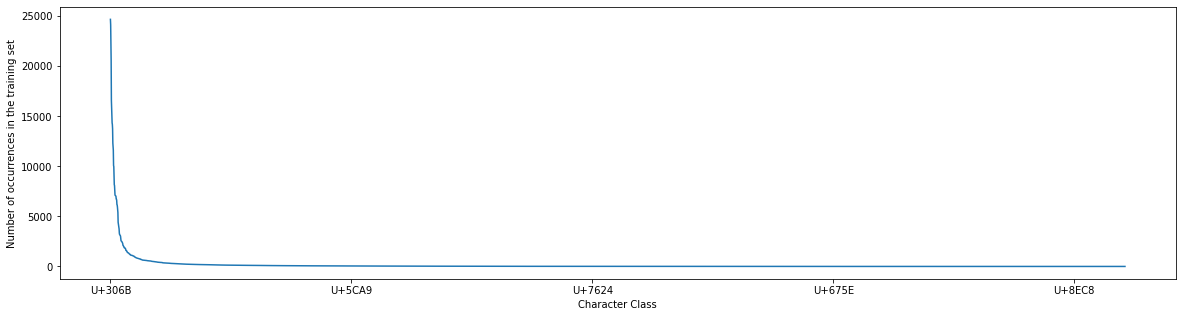

In [25]:
character_class_count = labels_df.class_name.value_counts()

plt.figure(figsize=(20, 5))

character_class_count.plot()

plt.xlabel("Character Class")
plt.ylabel("Number of occurrences in the training set")

plt.show()

In [26]:
character_class_count.describe()

count     4212.000000
mean       162.265907
std       1106.475303
min          1.000000
25%          2.000000
50%          9.000000
75%         44.000000
max      24685.000000
Name: class_name, dtype: float64

From the plot we can see that some of the classes appear a lot more than the other ones. Our dataset is highly imbalanced. Also while 75% percent of the classes appear only around 9 times in the dataset, for one particular character we have around 25k samples. We have 162 records on average per class. This seems fine, but it is actually influenced by the very high frequency for only a few a characters. Let see which ones are those.

First let's read in the unicode translation table, so that we can actually see which classes respond to which characters.

In [27]:
unicode_translation = pd.read_csv("data/unicode_translation.csv", index_col=0, squeeze=True)

In [28]:
top_10_freq_classes = character_class_count.head(10)
last_10_freq_classes = character_class_count.tail(10)
unicode_translation[top_10_freq_classes.index], unicode_translation[last_10_freq_classes.index]

(U+306B    に
 U+306E    の
 U+3057    し
 U+3066    て
 U+3068    と
 U+3092    を
 U+306F    は
 U+304B    か
 U+308A    り
 U+306A    な
 Name: char, dtype: object,
 U+7C5F    籟
 U+7C46    籆
 U+7C1F    簟
 U+7C17    簗
 U+7C13    簓
 U+7C12    簒
 U+7BFC    篼
 U+7BF7    篷
 U+7BD7    篗
 U+FF2F    Ｏ
 Name: char, dtype: object)

So the most frequently appearing characters correspond to single sounds/letters. The last ones are more complex and specific words, which isn't that surprising. But we want our model do classify well all different types of classes and generalize even in these extreme scenarios. 

===================================================================================================================

Lastly, let's look at the dimensions of the images, which we have. It might be better for us to crop them into regions, before we give them to the model, because they are probably too large.

In [ ]:
# def read_image_tf(image_id):
#     """
#     Reads an image from the training directory into tensorflow and returns it.
#     """
#     return tf.io.read_file(f'./data/train_images/{image_id}.jpg')

In [ ]:
# def get_image_shape(image_id):
#     """
#     Read an image end extract its dimensions.
#     """
#     return imread(f'./data/train_images/{image_id}.jpg').shape

In [ ]:
# all_images_dims = pd.DataFrame(all_images_dims.to_list(), columns=["height", "width", "channels"])

In [ ]:
# all_images_dims.describe()

As we can see from the table above, the mean height for an image is around 3000 pixels and the mean width - around 2000. This is a lot. 

In [ ]:
# timage = read_image_tf(unique_image_ids.iloc[0])

In [ ]:
# def split_image(image3, tile_size):
#     image_shape = tf.shape(image3)
#     print(image_shape)
#     tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1], image_shape[2]])
#     serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])
#     return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])

In [ ]:
# def pad_image_to_tile_multiple(image3, tile_size, padding="CONSTANT"):
#     imagesize = tf.shape(image3)[0:2]
#     padding_ = tf.cast(tf.math.ceil(imagesize / tile_size), "int32") * tile_size - imagesize
#     return tf.pad(image3, [[0, padding_[0]], [0, padding_[1]], [0, 0]], padding)


In [ ]:
# # tf.image.crop_and_resize(timage, )
# # image = tf.expand_dims(tf.io.decode_image(timage), axis=0)
# BATCH_SIZE = 1
# NUM_BOXES = 5
# CHANNELS = 3
# CROP_SIZE = (512, 512)

# im = tf.io.decode_image(timage).numpy()
# # plt.imshow(image)
# boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0, maxval=BATCH_SIZE, dtype=tf.int32)
# # output = split_image(image[0], CROP_SIZE)
# # output.shape

In [ ]:
# M = im.shape[0]//2
# N = im.shape[1]//2

# tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
# for i in tiles:
#     plt.imshow(i)
#     plt.show()

In [ ]:
# for i in range(len(output)):
#     plt.subplot(output.shape[0] // 3 + 1, 3, i + 1)
#     plt.imshow(output[i].numpy().astype('uint8'))
# output.shape[0] // 3 + 1

===================================================================================================================

But before we look at possible solutions like data augmentation, let's create a validation set and set up the training data in a `tfrecord` format.

Let's try to display the data for one of the images in the dataset, to see what it looks like.

In [37]:
def get_image_shape(image_id):
    """
    Read an image end extract its dimensions.
    """
    return imread(f'./data/train_images/{image_id}.jpg').shape

In [38]:
unique_image_ids = pd.Series(labels_df.image_id.unique())
all_images_dims = unique_image_ids.apply(get_image_shape)

In [29]:
def read_image(image_id):
    """
    Reads an image from the training directory into a numpy array and returns it.
    """
    return imread(f'./data/train_images/{image_id}.jpg')

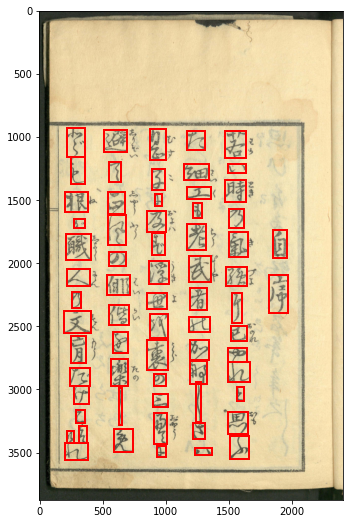

In [30]:
image_id_test = labels_df.iloc[0].image_id
labels_test = labels_df[labels_df.image_id == image_id_test]
labels_coords_test = labels_test[["x", "y", "w", "h"]]

image_data = read_image(image_id_test)

fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(image_data)

for box_coords in labels_coords_test.itertuples():
    bounding_box_fig = Rectangle((box_coords.x, box_coords.y), box_coords.w, box_coords.h, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(bounding_box_fig)

plt.show()

The function below now will create a `tf.train.Example` from a given image data and labels.

In [31]:
def create_tf_example(image_name):
    """
    Creates a tf.Example proto from a given image name.
    
    Parameters
    ----------
    image_name: The name of the jpg image.

    Returns
    ----------
    example: The created tf.Example.
    """
    
    filename = b'{image_name}.jpg'
    image_path = f'data/train_images/{image_name}.jpg'
    image_format = b'jpg'
    
    # Read the image file as bytes.
    with tf.io.gfile.GFile('./data/train_images/100241706_00004_2.jpg', 'rb') as f:
        encoded_image_data = f.read()
    
#     decoded_image_data = tf.io.decode_image(encoded_image_data)
#     encoded_image_data = tf.io.encode_jpeg(tf.cast(tf.image.resize(decoded_image_data, (512, 512)), "uint8")).numpy()
    
    # Extract the image's dimensions.
    image_shape_tensor = tf.io.extract_jpeg_shape(encoded_image_data)
    
    height = image_shape_tensor[0].numpy()
    width = image_shape_tensor[1].numpy()
    
    # Get the rows from the dataframe, corresponding to the given image.
    current_labels = labels_df[labels_df.image_id == image_name]
    
    xmins_np = current_labels["x"].to_numpy()
    xmaxs_np = current_labels["w"].to_numpy() + xmins_np
    ymins_np = current_labels["y"].to_numpy()
    ymaxs_np = current_labels["h"].to_numpy() + ymins_np

    # Scaling the coordinates to the range [0, 1] and converting them back to regular python lists.
    xmins = xmins_np / width
    xmaxs = xmaxs_np / width
    ymins = ymins_np / height
    ymaxs = ymaxs_np / height
    
    # Convert the string labels to a list of bytes.
    classes_text = current_labels["class_name"] \
                    .apply(lambda cls: bytes(cls, encoding="utf-8")) \
                    .to_list()
    
    classes = current_labels["class"].to_list()

    # Create the actual tf.Example object.
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    print(f'Created tf_example for {image_name}')
    return tf_example

Before we continue on creating the desired `tfrecord` files, let's create a stratified validation split.

Something, which might help us with the validation of the models is to test them on all the different styles of pages. The images, which we are provided with in the training set come from a few different books. For example: `100241706_00005_1` and `100241706_00016_2`, which we can see below, are too pages from the same book, while `umgy012-041` and `umgy012-023` are from another one. The first "part" of the filename for each image signifies which book does the page come from. We can create a new dataframe, holding the names of all images in our dataset and their corresponding book titles. Then we can split them randomly into a training set (85% percent of the data, because we don't have that many samples) and a validation set. For testing we will use the data provided by the competition. 

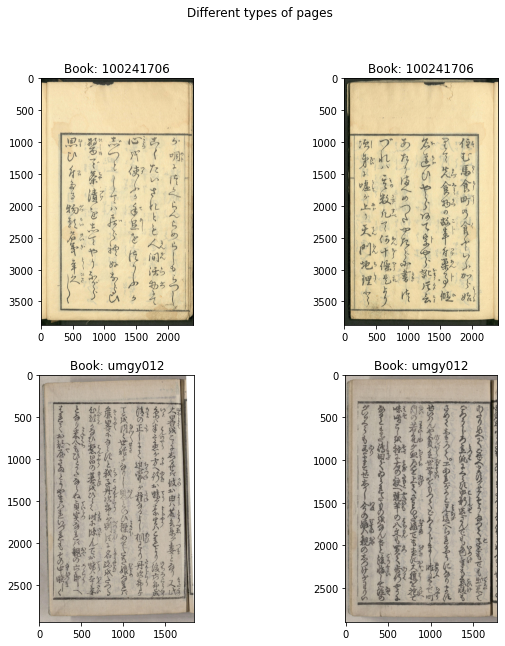

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Different types of pages')

ax1.set_title("Book: 100241706")
ax2.set_title("Book: 100241706")
ax1.imshow(read_image('100241706_00005_1'))
ax2.imshow(read_image('100241706_00005_2'))

ax3.set_title("Book: umgy012")
ax4.set_title("Book: umgy012")
ax3.imshow(read_image('umgy012-041'))
ax4.imshow(read_image('umgy012-023'))

In [34]:
def extract_book(filename):
    """
    Function to extract the book_id from a filename of an image in the dataset.
    """
    # Three of the book_ids contain only letters and need to be split by the first occurance of a digit.
    if filename[0] >= 'a' and filename[0] <= 'z':
        return re.split(r'(^[^\d]+)', filename)[1]
    # The rest can be simply split by the first '-' or '_' symbol
    else:
        return re.split(r"[-_]", filename)[0]

In [39]:
pages_df = pd.DataFrame([unique_image_ids, unique_image_ids]).T
pages_df.columns = ["image_id", "book_id"]
pages_df.book_id = pages_df.book_id.apply(extract_book)
pages_df

,image_id,book_id
0,100241706_00004_2,100241706
1,100241706_00005_1,100241706
2,100241706_00005_2,100241706
3,100241706_00006_1,100241706
4,100241706_00007_2,100241706
...,...,...
3600,umgy012-038,umgy
3601,umgy012-039,umgy
3602,umgy012-040,umgy
3603,umgy012-041,umgy


We can now create a stratified validation split based on the `book_id`.

In [40]:
training_ids, validation_ids = train_test_split(pages_df.image_id, train_size = 0.90, stratify = pages_df.book_id, random_state=23)
len(training_ids), len(validation_ids)

(3244, 361)

Finally we are ready to build the two different `tfrecord` files for testing and validation. 

In [41]:
def create_tfrecord(filename, image_ids):
    """
    Creates a tfrecord file with all the data for the given image_ids and saves it with the given filename.
    """
    writer = tf.io.TFRecordWriter(filename)
    for image_id in image_ids:
        tf_example = create_tf_example(image_id)
        writer.write(tf_example.SerializeToString())
    writer.close()
    pass

In [59]:
create_tfrecord("./data/train.record", training_ids)
create_tfrecord("./data/validation.record", validation_ids)

Created tf_example for hnsd008-038
Created tf_example for brsk004-019
Created tf_example for 200021660-00032_2
Created tf_example for 100249537_00035_1
Created tf_example for 200015779_00011_2
Created tf_example for 200021644_00025_2
Created tf_example for 200021802-00029_1
Created tf_example for hnsd001-037
Created tf_example for 200014740-00018_1
Created tf_example for 100249537_00017_2
Created tf_example for 200003076_00137_2
Created tf_example for 200003076_00031_2
Created tf_example for 200021853-00005_2
Created tf_example for 200003076_00147_2
Created tf_example for hnsd008-036
Created tf_example for umgy007-013
Created tf_example for brsk002-046
Created tf_example for hnsd010-009
Created tf_example for 100249376_00004_1
Created tf_example for umgy010-004
Created tf_example for 200021925-00018_2
Created tf_example for 100241706_00029_1
Created tf_example for 200003076_00166_1
Created tf_example for hnsd007-049
Created tf_example for 200021853-00014_1
Created tf_example for umgy00

Created tf_example for 200003076_00119_1
Created tf_example for brsk004-021
Created tf_example for 200003076_00025_1
Created tf_example for 200021763-00034_2
Created tf_example for hnsd010-036
Created tf_example for 200005598_00007_1
Created tf_example for hnsd012-018
Created tf_example for umgy002-019
Created tf_example for 200021637-00004_2
Created tf_example for 200021853-00033_2
Created tf_example for hnsd001-044
Created tf_example for 200021853-00013_1
Created tf_example for 200021851_00003_2
Created tf_example for 200003967_00042_1
Created tf_example for hnsd006-030
Created tf_example for 200021851_00020_2
Created tf_example for hnsd007-024
Created tf_example for 200021763-00037_1
Created tf_example for 200014740-00064_1
Created tf_example for umgy003-023
Created tf_example for 200003076_00078_2
Created tf_example for 100249376_00006_1
Created tf_example for umgy006-024
Created tf_example for 200021644_00020_1
Created tf_example for hnsd007-019
Created tf_example for 100249371_00

Created tf_example for brsk003-017
Created tf_example for 200015779_00054_1
Created tf_example for 200003076_00068_2
Created tf_example for 200021712-00020_1
Created tf_example for hnsd007-035
Created tf_example for hnsd009-027
Created tf_example for 200014685-00007_2
Created tf_example for 200021851_00024_2
Created tf_example for 200014685-00023_1
Created tf_example for 200021763-00016_2
Created tf_example for hnsd006-011
Created tf_example for 200021851_00019_1
Created tf_example for 200005598_00025_2
Created tf_example for 200021660-00016_1
Created tf_example for 200021853-00030_1
Created tf_example for hnsd002-034
Created tf_example for 200003076_00061_2
Created tf_example for umgy004-034
Created tf_example for 200021712-00072_2
Created tf_example for umgy009-001
Created tf_example for 200015779_00149_2
Created tf_example for brsk003-029
Created tf_example for hnsd009-009
Created tf_example for brsk003-008
Created tf_example for umgy010-016
Created tf_example for 100249537_00017_1


Created tf_example for 200021660-00054_1
Created tf_example for 100241706_00027_1
Created tf_example for hnsd001-010
Created tf_example for 100249476_00021_2
Created tf_example for 200003967_00029_1
Created tf_example for 200015779_00023_1
Created tf_example for 200021853-00032_2
Created tf_example for 200021712-00048_1
Created tf_example for hnsd005-038
Created tf_example for 100249537_00060_1
Created tf_example for umgy007-035
Created tf_example for 200003967_00012_1
Created tf_example for 200021660-00052_1
Created tf_example for 100249537_00065_2
Created tf_example for hnsd003-031
Created tf_example for 200021869-00011_2
Created tf_example for 200021763-00004_2
Created tf_example for hnsd002-036
Created tf_example for brsk001-010
Created tf_example for umgy003-015
Created tf_example for 100249537_00020_2
Created tf_example for 200014685-00024_2
Created tf_example for umgy009-020
Created tf_example for brsk003-007
Created tf_example for hnsd010-006
Created tf_example for 200004148_00

Created tf_example for 200003076_00080_2
Created tf_example for 100249371_00035_2
Created tf_example for 200014740-00078_2
Created tf_example for 200014685-00022_1
Created tf_example for 200022050-00005_2
Created tf_example for 200021802-00022_1
Created tf_example for 100249476_00026_1
Created tf_example for 200015779_00025_2
Created tf_example for 100249376_00042_2
Created tf_example for umgy010-015
Created tf_example for 200015779_00100_2
Created tf_example for 100249537_00085_1
Created tf_example for umgy009-019
Created tf_example for 200021712-00019_1
Created tf_example for 200021637-00011_2
Created tf_example for 200014685-00022_2
Created tf_example for 100249376_00044_2
Created tf_example for 200021763-00040_2
Created tf_example for 200021802-00005_1
Created tf_example for 200014740-00070_2
Created tf_example for 200021660-00060_2
Created tf_example for 200015779_00143_1
Created tf_example for 200014740-00092_1
Created tf_example for brsk002-052
Created tf_example for 200021853-0

Created tf_example for hnsd010-021
Created tf_example for hnsd006-005
Created tf_example for 100249376_00027_2
Created tf_example for 200003967_00030_1
Created tf_example for 200004148_00004_2
Created tf_example for 200015779_00014_2
Created tf_example for hnsd011-009
Created tf_example for 200021644_00035_1
Created tf_example for 200015779_00060_2
Created tf_example for hnsd001-014
Created tf_example for 200014740-00005_2
Created tf_example for 200003967_00024_2
Created tf_example for 200014740-00034_2
Created tf_example for umgy005-031
Created tf_example for umgy011-009
Created tf_example for 100249376_00038_2
Created tf_example for 100249376_00054_2
Created tf_example for 200003967_00027_1
Created tf_example for umgy001-026
Created tf_example for 100241706_00038_1
Created tf_example for 200015779_00103_1
Created tf_example for 200014740-00073_1
Created tf_example for brsk004-005
Created tf_example for 100249371_00031_1
Created tf_example for umgy002-038
Created tf_example for hnsd00

Created tf_example for 100249537_00051_1
Created tf_example for 200021802-00048_2
Created tf_example for umgy011-019
Created tf_example for hnsd004-048
Created tf_example for 200003076_00082_1
Created tf_example for hnsd005-006
Created tf_example for hnsd008-040
Created tf_example for brsk002-035
Created tf_example for 200004148_00027_2
Created tf_example for brsk001-016
Created tf_example for umgy005-011
Created tf_example for hnsd004-031
Created tf_example for 200021660-00045_2
Created tf_example for 100249537_00047_2
Created tf_example for 100249371_00021_1
Created tf_example for 200003076_00158_1
Created tf_example for umgy003-020
Created tf_example for 200005598_00033_1
Created tf_example for brsk002-059
Created tf_example for hnsd002-018
Created tf_example for hnsd005-025
Created tf_example for 200021851_00006_1
Created tf_example for 200021851_00023_2
Created tf_example for brsk005-038
Created tf_example for hnsd007-043
Created tf_example for 200021660-00059_2
Created tf_example

Created tf_example for 100249371_00009_1
Created tf_example for hnsd012-015
Created tf_example for 200003967_00021_2
Created tf_example for 200021925-00023_2
Created tf_example for 200021660-00069_1
Created tf_example for 200021637-00006_2
Created tf_example for 200003076_00019_1
Created tf_example for umgy010-037
Created tf_example for 200003076_00071_2
Created tf_example for umgy009-041
Created tf_example for umgy001-031
Created tf_example for 200021853-00038_1
Created tf_example for 200014740-00033_2
Created tf_example for 200015779_00006_1
Created tf_example for 200021869-00002
Created tf_example for hnsd010-046
Created tf_example for 200021869-00008_2
Created tf_example for 200014740-00042_2
Created tf_example for 200021853-00024_1
Created tf_example for 200004148_00022_2
Created tf_example for 100249416_00034_1
Created tf_example for 200004148_00091_1
Created tf_example for hnsd011-031
Created tf_example for umgy006-001
Created tf_example for 100241706_00037_1
Created tf_example 

Created tf_example for umgy010-039
Created tf_example for 200021853-00019_2
Created tf_example for hnsd009-031
Created tf_example for 200003076_00017_2
Created tf_example for 200021802-00019_1
Created tf_example for 200021851_00008_1
Created tf_example for hnsd011-025
Created tf_example for 200015779_00031_1
Created tf_example for 200003076_00134_2
Created tf_example for 100241706_00017_2
Created tf_example for hnsd003-008
Created tf_example for hnsd011-020
Created tf_example for hnsd008-007
Created tf_example for 200021763-00002_2
Created tf_example for brsk002-014
Created tf_example for 200015779_00062_2
Created tf_example for hnsd004-027
Created tf_example for 200015779_00039_1
Created tf_example for 200015779_00019_1
Created tf_example for 200015779_00045_1
Created tf_example for 200021660-00080_2
Created tf_example for 200006663_00004_1
Created tf_example for 200014740-00016_2
Created tf_example for brsk005-015
Created tf_example for 200021802-00041_1
Created tf_example for 100249

Created tf_example for umgy012-042
Created tf_example for 200021644_00015_1
Created tf_example for 200021802-00024_2
Created tf_example for 200021660-00050_1
Created tf_example for brsk002-021
Created tf_example for 100249376_00020_1
Created tf_example for 200021763-00041_1
Created tf_example for hnsd005-031
Created tf_example for brsk003-015
Created tf_example for 200003076_00028_1
Created tf_example for 200003076_00008_2
Created tf_example for 200021660-00053_1
Created tf_example for 200021851_00012_1
Created tf_example for brsk001-004
Created tf_example for 200021660-00025_1
Created tf_example for 200003076_00092_1
Created tf_example for 200021851_00005_1
Created tf_example for 200003967_00033_2
Created tf_example for 100249376_00019_1
Created tf_example for 100249376_00024_2
Created tf_example for 200004148_00077_2
Created tf_example for 200015779_00135_1
Created tf_example for 200021712-00049_2
Created tf_example for 200015779_00122_2
Created tf_example for brsk002-063
Created tf_

Created tf_example for 200021851_00016_2
Created tf_example for 200005598_00042_2
Created tf_example for 200015779_00096_1
Created tf_example for 200021925-00011_2
Created tf_example for hnsd009-011
Created tf_example for hnsd003-024
Created tf_example for 200014740-00087_1
Created tf_example for 200021712-00003_2
Created tf_example for 200014740-00071_2
Created tf_example for 200022050-00007_2
Created tf_example for umgy008-039
Created tf_example for umgy001-039
Created tf_example for 200021802-00044_1
Created tf_example for 100249371_00005_1
Created tf_example for 200021712-00077_1
Created tf_example for 100241706_00005_2
Created tf_example for 200003076_00030_2
Created tf_example for 100249537_00024_2
Created tf_example for 200014740-00005_1
Created tf_example for brsk002-017
Created tf_example for umgy001-011
Created tf_example for 100249376_00011_2
Created tf_example for 200003076_00078_1
Created tf_example for 200015779_00097_2
Created tf_example for brsk001-009
Created tf_exampl

Created tf_example for brsk005-037
Created tf_example for hnsd005-010
Created tf_example for umgy003-009
Created tf_example for 200005598_00028_2
Created tf_example for 200021712-00083_1
Created tf_example for 100249537_00007_1
Created tf_example for 200021802-00013_2
Created tf_example for 200021712-00020_2
Created tf_example for 200021802-00045_2
Created tf_example for hnsd001-045
Created tf_example for 200014740-00022_1
Created tf_example for hnsd007-014
Created tf_example for hnsd011-027
Created tf_example for hnsd003-041
Created tf_example for 200004148_00018_1
Created tf_example for hnsd002-023
Created tf_example for hnsd001-032
Created tf_example for hnsd012-017
Created tf_example for umgy012-001
Created tf_example for 200021802-00021_2
Created tf_example for hnsd011-016
Created tf_example for 200005598_00040_1
Created tf_example for hnsd010-007
Created tf_example for 200003076_00006_1
Created tf_example for hnsd004-043
Created tf_example for 200003967_00028_1
Created tf_example

Created tf_example for umgy004-033
Created tf_example for umgy011-013
Created tf_example for 200015779_00020_2
Created tf_example for brsk004-027
Created tf_example for 200005598_00040_2
Created tf_example for umgy009-035
Created tf_example for 100249371_00004_2
Created tf_example for 200003076_00069_1
Created tf_example for 200003076_00074_2
Created tf_example for hnsd003-001
Created tf_example for 100249376_00022_1
Created tf_example for 200021712-00047_1
Created tf_example for umgy010-019
Created tf_example for 200021763-00041_2
Created tf_example for 200006663_00006_2
Created tf_example for brsk001-036
Created tf_example for 100249537_00007_2
Created tf_example for hnsd008-001
Created tf_example for hnsd001-026
Created tf_example for 200015779_00149_1
Created tf_example for umgy001-023
Created tf_example for 200021763-00049_1
Created tf_example for 200014685-00007_1
Created tf_example for 200021802-00012_2
Created tf_example for umgy012-036
Created tf_example for hnsd008-030
Create

Created tf_example for 200005598_00009_1
Created tf_example for 100249376_00023_2
Created tf_example for 200014740-00064_2
Created tf_example for 100249376_00042_1
Created tf_example for 200021644_00020_2
Created tf_example for 200004148_00005_2
Created tf_example for 200021660-00041_2
Created tf_example for 200005598_00049_1
Created tf_example for 100249371_00010_1
Created tf_example for umgy011-018
Created tf_example for 200021712-00029_2
Created tf_example for 200021644_00041_2
Created tf_example for hnsd009-035
Created tf_example for umgy011-032
Created tf_example for 200015779_00156_2
Created tf_example for 100249537_00044_2
Created tf_example for 200021712-00050_2
Created tf_example for 100249537_00073_1
Created tf_example for 200021853-00026_1
Created tf_example for umgy004-023
Created tf_example for 200015779_00147_1
Created tf_example for hnsd012-013
Created tf_example for 200015779_00142_1
Created tf_example for 200021660-00081_2
Created tf_example for 200014740-00021_1
Creat

Created tf_example for 200021644_00024_1
Created tf_example for 200021712-00082_2
Created tf_example for hnsd010-014
Created tf_example for 200003967_00035_2
Created tf_example for 200021763-00030_2
Created tf_example for hnsd006-027
Created tf_example for umgy007-039
Created tf_example for 200021853-00004_1
Created tf_example for 200003076_00177_1
Created tf_example for umgy004-044
Created tf_example for 200021660-00043_1
Created tf_example for 200015779_00037_2
Created tf_example for 100249537_00013_2
Created tf_example for 200004148_00083_2
Created tf_example for 200021925-00015_1
Created tf_example for 200014740-00083_1
Created tf_example for 100249376_00047_2
Created tf_example for umgy007-043
Created tf_example for 200004148_00064_1
Created tf_example for 200015779_00134_1
Created tf_example for 200021660-00026_1
Created tf_example for 100249371_00020_1
Created tf_example for 200015779_00012_1
Created tf_example for 200003076_00105_1
Created tf_example for hnsd005-013
Created tf_

Created tf_example for 200021869-00014_1
Created tf_example for 200021763-00006_1
Created tf_example for 200014740-00015_2
Created tf_example for hnsd012-037
Created tf_example for 200015779_00052_2
Created tf_example for 100249537_00068_1
Created tf_example for umgy005-022
Created tf_example for 200004148_00034_2
Created tf_example for hnsd005-008
Created tf_example for 200003076_00080_1
Created tf_example for hnsd004-047
Created tf_example for 200005598_00004_1
Created tf_example for 200021644_00043_1
Created tf_example for 200021853-00010_1
Created tf_example for 200004148_00064_2
Created tf_example for 100241706_00031_1
Created tf_example for hnsd011-038
Created tf_example for 200014740-00009_1
Created tf_example for 200014740-00081_2
Created tf_example for brsk002-039
Created tf_example for hnsd003-036
Created tf_example for 200021802-00036_1
Created tf_example for umgy004-045
Created tf_example for 100249376_00046_2
Created tf_example for brsk005-009
Created tf_example for 100249

Created tf_example for hnsd004-046
Created tf_example for 200005598_00019_2
Created tf_example for umgy011-021
Created tf_example for umgy012-032
Created tf_example for brsk002-060
Created tf_example for 200021712-00042_2
Created tf_example for 200021660-00056_2
Created tf_example for hnsd012-036
Created tf_example for 200021644_00016_2
Created tf_example for 200015779_00144_2
Created tf_example for 200015779_00064_2
Created tf_example for umgy008-006
Created tf_example for umgy001-010
Created tf_example for 100241706_00019_1
Created tf_example for umgy003-013
Created tf_example for brsk005-033
Created tf_example for brsk002-015
Created tf_example for hnsd006-020
Created tf_example for 200003076_00045_1
Created tf_example for 200021763-00043_2
Created tf_example for umgy002-012
Created tf_example for hnsd002-027
Created tf_example for 200021712-00047_2
Created tf_example for 200014740-00046_1
Created tf_example for 200021853-00018_1
Created tf_example for 200003967_00020_2
Created tf_e

Now let's read in those files and create `tf.data.Dataset`s from them.

In [42]:
training_dataset = tf.data.TFRecordDataset("./data/train.record")
validation_dataset = tf.data.TFRecordDataset("./data/validation.record")

There are generally two approaches, regarding the model architecture:
    Single model, which combines the localization and classification tasks into a single more complex model. Faster-RCNN and CenterNet are such models. 
    2-stage architecture, where one model does the localization of the objects in the image and another one classifies them.
    
For a one-stage model, I've chosen to start with a CenterNet architecture and a ResNet backbone. CenterNet tries to solve some of Faster-RCNN's problems. It abandons the anchor methodology and instead tries to learn to create a keypoint heatmap, which is later predicted by one part of the model. Another one regresses each box' dimensions and offsets just like in other models. Only here instead of doing regular NMS (non-max suppression) to remove unnecessary predictions, which compares every two boxes' IoU, the algorithm uses the predicted heatmap to discard all the boxes, where the center doesn't coincide with the actual region on the heatmap. This is a lot faster and computationally cheaper. That is why first I'll try this architecture.
I've chosen a residual network for the backbone, because it is also easier to compute, compared to for example HourGlass. If the performance is significantly worse, we will change it up later.

Now we will prepare our model for training using the proper config file and loading in the pretrained weights for the backbone network.

In [43]:
tf.keras.backend.clear_session()

NUM_CLASSES = len(labels_df[labels_df.image_id.isin(training_ids.values)]["class"].unique())
PIPELINE_CONFIG = './models/centernet_resnet101_v1_fpn_512x512/pipeline.config'
CKPT_PATH = './models/centernet_resnet101_v1_fpn_512x512/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG)
model_config = configs['model']
model_config.center_net.num_classes = NUM_CLASSES

detection_model = model_builder.build(model_config=model_config, is_training=True)

In [49]:
detection_model.build((None, 512, 512, 3))

In [57]:
detection_model.prediction_head_dict['object_center'][0].layers

In [58]:
detection_model.training_step

ValueError: Training step was not provided to the model.

In [7]:
first_example = tf.train.Example.FromString(iter(training_dataset).next().numpy())

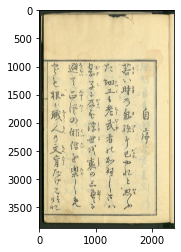

In [48]:
plt.imshow(tf.io.decode_image(first_example.features.feature["image/encoded"].bytes_list.value[0]))
plt.show()